In [1]:
import polars as pl
import tensorflow as tf
from ml_collections import ConfigDict
import temporal_fusion_transformer as tft
import jax
import jax.numpy as jnp
import numpy as np
from absl_extra import logging_utils, flax_utils
from tqdm.auto import tqdm
from keras.utils import FeatureSpace
import matplotlib
import matplotlib.pyplot as plt
import matplotx
import datetime
from datetime import datetime
import matplotlib.dates as mdates


logging_utils.setup_logging(log_level="INFO")
matplotlib.style.use(matplotx.styles.dufte)

config = ConfigDict(
    {
        "prng_seed": 69,
        "fixed_params": {
            "num_encoder_steps": 168,  # 7 * 24
            "total_time_steps": 192,  # 8 * 24
            "num_outputs": 1,
            "known_categories_sizes": [31, 24, 7, 12],  # day of month  # hour of the day  # day of the week  # month
            "static_categories_sizes": [369],  # id
            "input_observed_idx": [],
            "input_static_idx": [0],
            "input_known_real_idx": [1, 2],
            "input_known_categorical_idx": [3, 4, 5, 6],
        },
        "hyperparams": {
            "num_attention_heads": 10,
            "num_decoder_blocks": 5,
            "latent_dim": 160,
            "dropout_rate": 0.1,
            "attention_dropout_rate": 0.1,
            "quantiles": [0.1, 0.5, 0.9],
        },
    }
)

Load model

In [3]:
model = tft.TemporalFusionTransformer.from_config_dict(config)

x_batch = jnp.ones([8, 8 * 24, 7])
rng_key = jax.random.PRNGKey(config.prng_seed)
params = model.init(rng_key, x_batch)["params"]
params = flax_utils.load_from_msgpack(params, "../model.msgpack")

2023-08-31 15:20:13,980:[xla_bridge.py:622->backends()]:INFO: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-08-31 15:20:13,980:[xla_bridge.py:622->backends()]:INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-08-31 15:20:13,981:[xla_bridge.py:622->backends()]:INFO: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


Load data & preprocessor

In [5]:
feature_space: FeatureSpace = tf.keras.models.load_model("../data/electricity/features_space.keras")
dataset = tf.data.Dataset.load("../data/electricity/test/", compression="GZIP")

/Users/artemsereda/miniconda3/envs/tft/lib/python3.10/site-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


Let's run inference for 1 entity only (MT_122)

In [6]:
lt = feature_space.preprocessors["id"].lookup_table.export()

lt[0][0], lt[1][0]

(<tf.Tensor: shape=(), dtype=string, numpy=b'MT_041'>,
 <tf.Tensor: shape=(), dtype=int64, numpy=309>)

We know that our `id` input is on 0 position among features (see config). 
We also know, that every unbatched input i a self-contained time-series for 1 id.

In [7]:
mt_122_dataset = dataset.filter(lambda x, y: (x[..., 0] == 350)[0])
mt_122_dataset = list(mt_122_dataset.as_numpy_iterator())
len(mt_122_dataset)

2023-08-31 15:25:43.649281: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


169

In [8]:
x_batch = np.asarray([i[0] for i in mt_122_dataset])
y_batch = np.asarray([i[1] for i in mt_122_dataset])

In [9]:
y_predicted = model.apply({"params": params}, x_batch)

y_batch.shape, y_predicted.shape

((169, 192, 1), (169, 24, 3))

In [10]:
y_past = y_batch[:, :168]
y_future = y_batch[:, 168:]

x_past = x_batch[:, :168]

x_past.shape, y_past.shape

((169, 168, 7), (169, 168, 1))

On indexes `[3, 4, 6]` we have `day of month`, `hour of the day` and `month` inputs.
We can use those to reconstruct the timestamp.

In [11]:
days_past = x_past[..., 3].reshape(-1)
hours_past = x_past[..., 4].reshape(-1)
months_past = x_past[..., 6].reshape(-1) + 1
x_past.shape, hours_past.shape, days_past.shape

((169, 168, 7), (28392,), (28392,))

In [12]:
timestamps = [
    datetime(year=2011, month=int(m), day=int(d), hour=int(h)) for m, d, h in zip(months_past, days_past, hours_past)
]

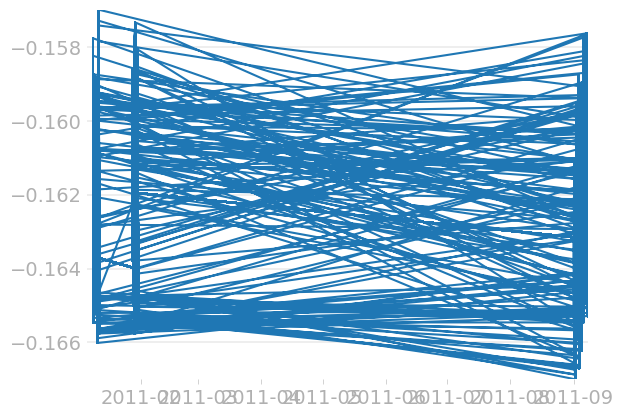

In [19]:
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M/%d/%H'))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
# TODO: how tf can we reconstruct the timestamp?

plt.plot(timestamps, y_past.reshape(-1))
# plt.plot(range(168, 192), y_future[0])
# plt.plot(range(168, 192), y_predicted[0,:,0])
# plt.plot(range(168, 192), y_predicted[0,:,1])
# plt.plot(range(168, 192), y_predicted[0,:,2])
# plt.gcf().autofmt_xdate()

# plt.legend(["past", "future", "q=0.1", "q=0.5", "q=0.9"])

In [14]:
x_past[..., 2].mean()

1.0

In [16]:
x_past[0].mean(axis=0)

array([350.      ,   1.      ,   1.      ,  17.857143,  11.5     ,
         3.      ,   0.      ], dtype=float32)